##### REFERENCE: This code is based on the Tensorflow Segmentation official tutorial
##### Copyright 2019 The TensorFlow Authors.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""

'\n%tensorflow_version 2.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\n\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

# Transfer Learning on PASCAL VOC 5i

##### Run git commands

In [ ]:
!git clone https://github.com/Temiloluwa/leo_segmentation.git --branch temi_jenny_pascalvoc5i

fatal: destination path 'leo_segmentation' already exists and is not an empty directory.


In [ ]:
import numpy as np
import tensorflow as tf
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

from collections import OrderedDict
from tqdm import tqdm
from PIL import Image
import time

In [ ]:
grouped_by_classes_root = os.path.join(os.getcwd(), "leo_segmentation", "leo_segmentation", "data", "grouped_by_classes")
former_data_root = os.path.join(os.getcwd(), "leo_segmentation", "leo_segmentation", "data", "original_pascalvoc5i", "pascal-5")

In [ ]:
classes = os.listdir(os.path.join(grouped_by_classes_root, "images"))
classes = [i.lower() for i in classes]
classes = sorted(classes)
classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [ ]:
def load_pickled_data(data_path):
    """Reads a pickle file"""
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def save_pickled_data(data, data_path):
    """Saves a pickle file"""
    with open(data_path, "wb") as f:
        data = pickle.dump(data,f)
    return data

## Load Dataset

In [ ]:
num_classes = 20
img_paths = {}
masks_paths = {}
for i in range(num_classes):
    if i not in img_paths:
        img_paths[classes[i]] = os.path.join(grouped_by_classes_root, "images",classes[i])
    
    if i not in masks_paths: 
        masks_paths[classes[i]] = os.path.join(grouped_by_classes_root, "masks", classes[i])

In [ ]:
masks_paths

{'aeroplane': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/aeroplane',
 'bicycle': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/bicycle',
 'bird': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/bird',
 'boat': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/boat',
 'bottle': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/bottle',
 'bus': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/bus',
 'car': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/car',
 'cat': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/cat',
 'chair': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/chair',
 'cow': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/masks/cow',
 'diningtable': '/content/leo_segmentation/leo_segmentation/data/grouped_by_classes/ma

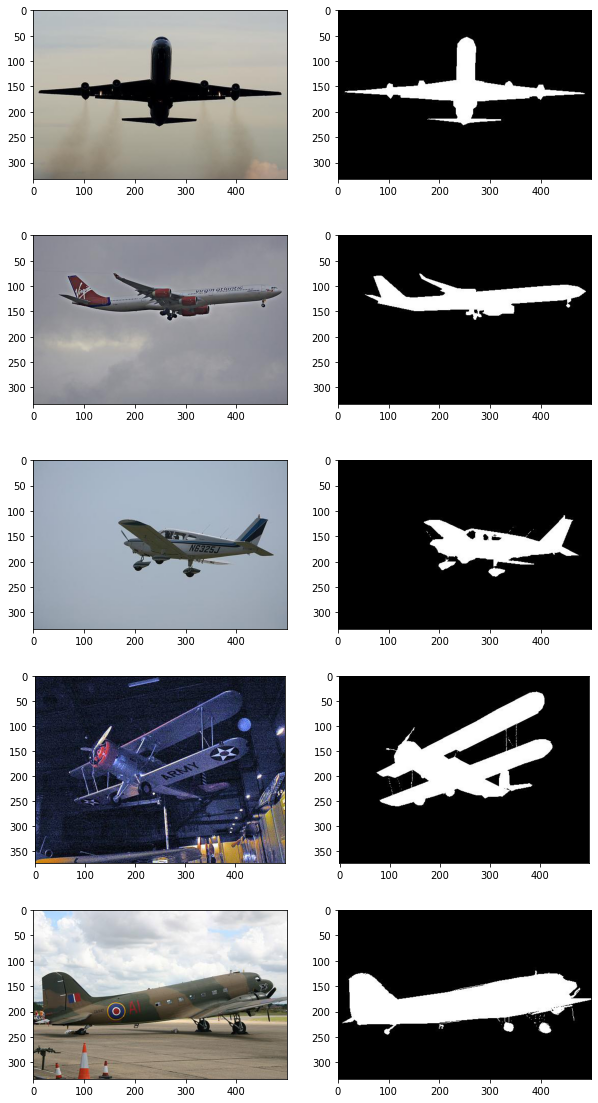

In [ ]:
selected_class = "aeroplane"
sample_img_path = img_paths[selected_class]
sample_mask_path = masks_paths[selected_class]
img_paths_list = os.listdir(sample_img_path)
mask_paths_list = os.listdir(sample_mask_path)
fig = plt.figure(figsize=(10, 20))
for i,idx in enumerate(np.random.randint(0,len(img_paths_list),5)):
    fig.add_subplot(5,2,i*2+1)
    img_path_selected = os.path.join(sample_img_path, img_paths_list[idx])
    plt.imshow(plt.imread(img_path_selected))
    
    fig.add_subplot(5,2,i*2+2)
    mask_path_selected = os.path.join(sample_mask_path, mask_paths_list[idx])
    plt.imshow(plt.imread(mask_path_selected))

In [ ]:
def load_pickled_data(data_path):
    """Reads a pickle file"""
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def save_pickled_data(data, data_path):
    """Saves a pickle file"""
    with open(data_path, "wb") as f:
        data = pickle.dump(data,f)
    return data

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
class Transform_image(object):

    def __init__(self, img_width, img_height):
        self.img_width = img_width
        self.img_height = img_height

    def __call__(self, im):
        w, h = im.size
        if h > w:
            im = im.transpose(method=Image.ROTATE_270).resize((img_width, img_height))
        else:
            im = im.resize((self.img_width, self.img_height))
        im = np.array(im)
        im = im.astype(np.float32)
        im = (im - 127.5)/127.5
        return im
    

class Transform_mask(object):

    def __init__(self, img_width, img_height):
        self.img_width = img_width
        self.img_height = img_height

    def __call__(self, im):
        w, h = im.size
        if h > w:
            im = im.transpose(method=Image.ROTATE_270).resize((img_width, img_height))
        else:
            im = im.resize((self.img_width, self.img_height))
        im = np.array(im)
        im = im.astype(np.float32)
        im = (im - 127.5)/127.5
        im = np.round(rgb2gray((im) > 0).astype(np.float32))
        return im

In [ ]:
img_height, img_width =  384,512

transform_image = Transform_image(img_width, img_height)
transform_mask = Transform_mask(img_width, img_height)

img_datasets = datasets.ImageFolder(root=os.path.join(grouped_by_classes_root, "images"), transform=transform_image)
mask_datasets = datasets.ImageFolder(root=os.path.join(grouped_by_classes_root, "masks"), transform=transform_mask)
    
total_num_imgs = len(img_datasets.imgs)
img_filenames = ["_".join(i[0].split("/")[-2:]) for i in img_datasets.imgs]
mask_filenames = ["_".join(i[0].split("/")[-2:]) for i in mask_datasets.imgs]

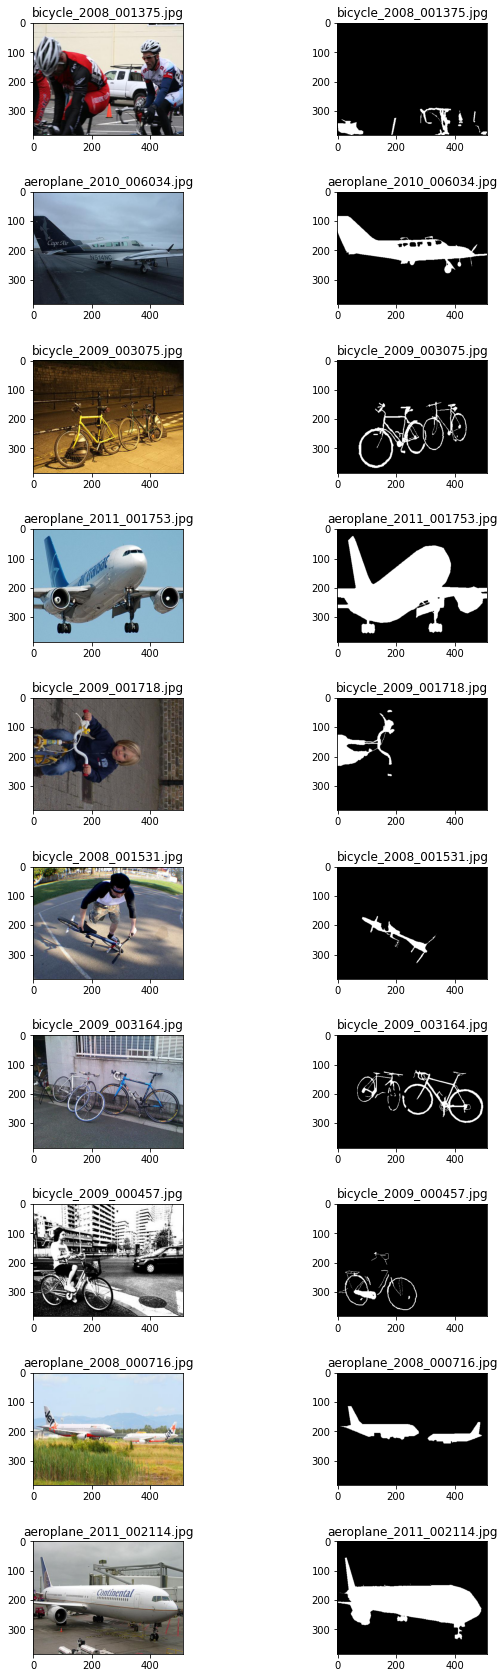

In [ ]:
bs = 200
dataloader_img = DataLoader(img_datasets, batch_size=bs,shuffle=False, num_workers=0)
dataloader_mask = DataLoader(mask_datasets, batch_size=bs,shuffle=False, num_workers=0)

image = next(iter(dataloader_img))[0]
mask = next(iter(dataloader_mask))[0]
fig = plt.figure(figsize=(10, 30))
num_images = 10
indices = np.random.randint(1,200, 20) 
for i in range(num_images):
    idx = indices[i]
    fig.add_subplot(10,2,i*2+1)
    plt.imshow((image.numpy()[idx]*127.5+127.5).astype("uint8"))
    plt.title(img_filenames[idx])

    fig.add_subplot(10,2,i*2+2)
    plt.imshow(mask.numpy()[idx].reshape(img_height, img_width), cmap="gray")
    plt.title((mask_filenames[idx]))
plt.subplots_adjust(hspace=0.5)
plt.show()

## Transfer Learning

In [ ]:
"""
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""

'\ntpu = tf.distribute.cluster_resolver.TPUClusterResolver()\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\n\n# instantiate a distribution strategy\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

In [ ]:
num_samples_train, num_channels = total_num_imgs, 3
num_samples_val  = 0
num_samples = num_samples_val + num_samples_train

#with tpu_strategy.scope():
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, num_channels), #375,500
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

layer_names = [
    'block_1_expand_relu',   # 188, 250, 96
    'block_3_expand_relu',   # 94, 125, 144
    'block_6_expand_relu',   # 47, 63, 192
    'block_13_expand_relu',  # 24, 32, 576
    'block_16_project',      # 12, 16, 320
]

layers = [base_model.get_layer(name).output for name in layer_names]
# Freeze the base_model
encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)
encoder.trainable = False

inputs = tf.keras.Input(shape=((img_height, img_width, num_channels)))
# Downsampling through the model
skips = encoder(inputs, training=False)

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', use_bias=False)
conv2 = tf.keras.layers.Conv2D(filters=16*2, kernel_size=3, strides=1, padding='same', use_bias=False)
conv3 = tf.keras.layers.Conv2D(filters=16*3, kernel_size=3, strides=1, padding='same', use_bias=False)
conv4 = tf.keras.layers.Conv2D(filters=16*4, kernel_size=3, strides=1, padding='same', use_bias=False)
conv5 = tf.keras.layers.Conv2D(filters=16*5, kernel_size=3, strides=1, padding='same', use_bias=False)
convfinal = tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding='same', use_bias=False)
upsample1 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
upsample2 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
upsample3 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
upsample4 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
upsample5 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
concat = tf.keras.layers.Concatenate()
encoder_output = skips[-1]

#comments on input size are wrong
print(encoder_output.shape)
x = conv1(encoder_output)# 12, 16, 320
x = tf.keras.layers.Activation('relu')(x)
x = upsample1(x) # 24, 32, 320
x = concat([x, skips[-2]])
x = conv2(x) # 24, 32, 576+320
x = tf.keras.layers.Activation('relu')(x)
x = upsample2(x) # 47, 63, 576+320
x = concat([x, skips[-3]]) # 47, 63, 576+320+192
x = conv3(x)# 47, 63, 576+320+192
x = tf.keras.layers.Activation('relu')(x)
x = upsample3(x)#94, 125, 576+320+192+144
x = concat([x, skips[-4]])#94, 125, 576+320+192+14
x = conv4(x)#94, 125, 576+320+192+144
x = tf.keras.layers.Activation('relu')(x)
x = upsample4(x) #188, 250, 96,576+320+192+144
x = concat([x, skips[-5]])#188, 250, 576+320+192+144+96
x = conv5(x)#188, 250, 576+320+192+144+96
x = tf.keras.layers.Activation('relu')(x)
x = upsample5(x)#375,500, 576+320+192+144+96
output = convfinal(x)
x = tf.keras.layers.Activation('sigmoid')(output)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

(None, 12, 16, 320)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 512, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 256, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 12, 16, 16)   46080       model[1][4]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 12, 16, 16)   0           conv2d[0][0]                     
________________________________________________________________________

In [ ]:
class SampleOneClass(Dataset):
    """
    CustomData dataset
    """
    def __init__(self):
        super(SampleOneClass, self).__init__()
        self.img_datasets = img_datasets
        self.mask_datasets = mask_datasets
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __getitem__(self, class_name):
        img_paths = [i[0] for i in self.img_datasets.imgs if class_name in i[0]]
        mask_paths = [i[0] for i in self.mask_datasets.imgs if class_name in i[0]]
        img_p_class = np.array([self.transform_image(Image.open(i)) for i in img_paths])
        msk_p_class = np.array([self.transform_mask(Image.open(i)) for i in mask_paths])

        return img_p_class,msk_p_class

    def __len__(self):
        return len(img_paths)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x, masks):
  logits = model(x)
  scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  scce_loss = scce(masks, logits)
  return scce_loss

def calc_iou_per_class(model, epoch, freq):
  class_ious = {}
  class_one = SampleOneClass()
  bs = 10
  for class_ in classes:
    imgs_in_class, msks_in_class = class_one[class_]
    iou_per_class = []
    for j in range(len(imgs_in_class)//bs+1):
      logits = model(imgs_in_class[bs*j:(bs+1)*j])
      targets = msks_in_class[bs*j:(bs+1)*j]
      for i in range(len(logits)):
        pred = np.argmax(logits[i].numpy(),axis=-1).astype(int)
        target = targets[i].astype(int)
        iou = np.sum(np.logical_and(target, pred))/np.sum(np.logical_or(target, pred))
        iou_per_class.append(iou)
    mean_iou_per_class = np.mean(iou_per_class)
    if epoch % freq == 0:
      print(f"Mean IOU for class {class_} is {mean_iou_per_class}")
    class_ious[f"{class_}"] = mean_iou_per_class
  return class_ious


def plot_prediction(model, input_data, masks, filenames):  
  fig = plt.figure(figsize=(30, 30))
  ground_truth_masks = masks
  for i in range(10):
    pred_masks = model(input_data[i].reshape(1,img_height,img_width,3))
    fig.add_subplot(10,3,i*3+1)
    plt.imshow((input_data[i]*127.5+127.5).astype("uint8"))
    plt.title(filenames[idx])

    fig.add_subplot(10,3,i*3+2)
    plt.imshow(ground_truth_masks[i].reshape(img_height, img_width), cmap="gray")
    plt.title("ground truth")

    fig.add_subplot(10,3,i*3+3)
    plt.imshow(np.argmax(pred_masks.numpy(),axis=-1)[0].reshape(img_height, img_width), cmap="gray")
    plt.title("predicted")
  plt.subplots_adjust(hspace=0.5)
  plt.show()
  return

def plot_stats(stats, col):
  fig = plt.figure(figsize=(10, 5))
  plt.plot(stats[col])
  plt.xlabel("epochs")
  plt.ylabel(col)
  plt.show()

@tf.function
def train_step(model, x, masks, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, masks)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

## Train

Epoch:1, Train loss:0.5186752080917358,Epoch Time:195.07356595993042
Epoch:2, Train loss:0.4707159996032715,Epoch Time:180.41422319412231
Epoch:3, Train loss:0.35794493556022644,Epoch Time:180.4698383808136
Epoch:4, Train loss:0.3525027632713318,Epoch Time:179.97544074058533
Mean IOU for class aeroplane is 0.5244092218516937
Mean IOU for class bicycle is 0.16416929152074933
Mean IOU for class bird is 0.38780713129887534
Mean IOU for class boat is 0.31056187698764665
Mean IOU for class bottle is 0.18415121268463658
Mean IOU for class bus is 0.5188715575080527
Mean IOU for class car is 0.3779764868090845
Mean IOU for class cat is 0.518823102794149
Mean IOU for class chair is 0.17322274100124885
Mean IOU for class cow is 0.5762170026210831
Mean IOU for class diningtable is 0.21877696460324617
Mean IOU for class dog is 0.4840211131177536
Mean IOU for class horse is 0.5891714330302212
Mean IOU for class motorbike is 0.4919528738552739
Mean IOU for class person is 0.3124262756850369
Mean IOU

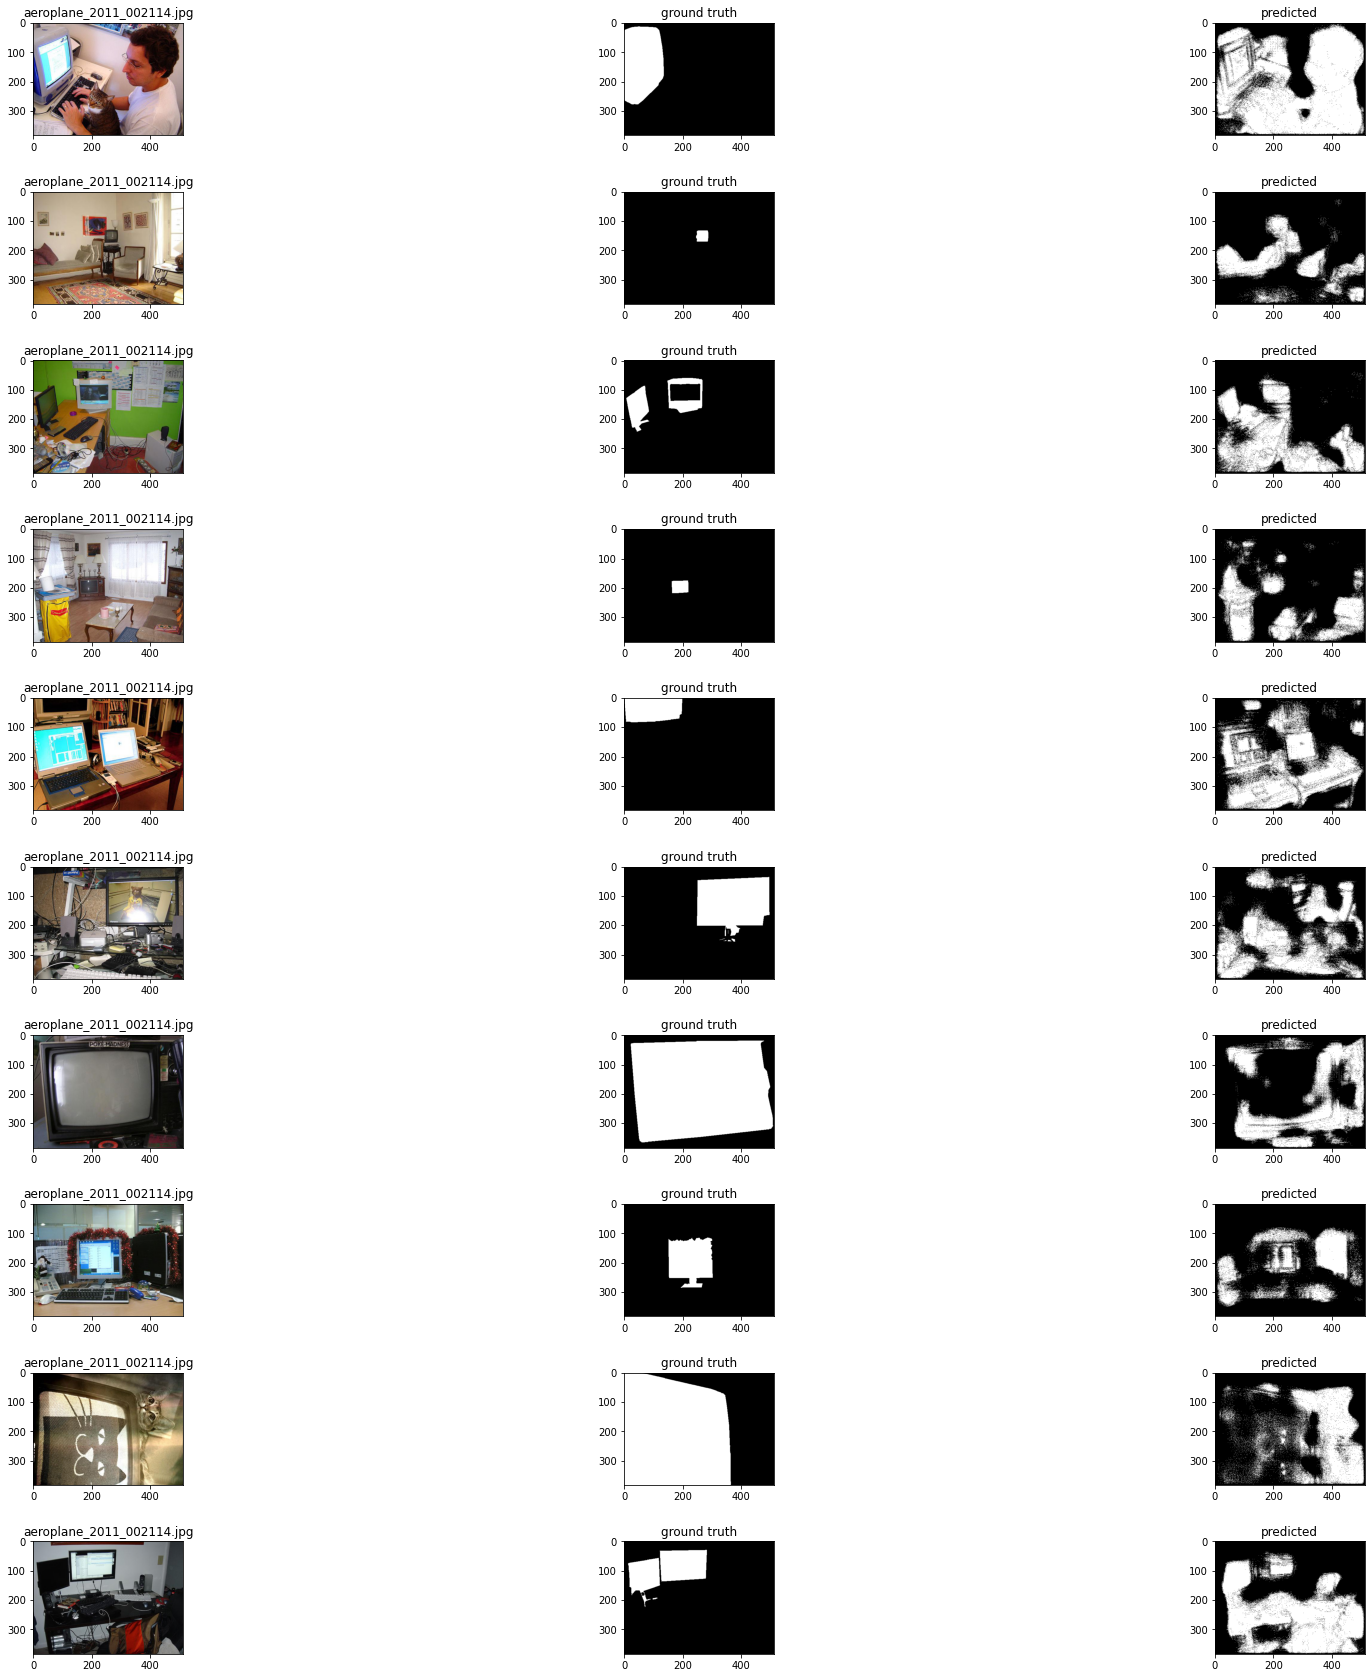

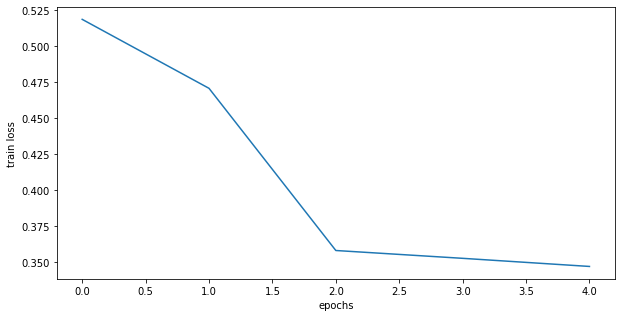

Epoch:6, Train loss:0.3380167484283447,Epoch Time:180.64559316635132
Epoch:7, Train loss:0.33318254351615906,Epoch Time:180.02421927452087
Epoch:8, Train loss:0.32998377084732056,Epoch Time:178.5880618095398
Epoch:9, Train loss:0.32746776938438416,Epoch Time:179.03079462051392
Mean IOU for class aeroplane is 0.5354516121578334
Mean IOU for class bicycle is 0.16057573916895213
Mean IOU for class bird is 0.4536787237148048
Mean IOU for class boat is 0.3056932271361586
Mean IOU for class bottle is 0.1937293801516755
Mean IOU for class bus is 0.5537223902344663
Mean IOU for class car is 0.39852692709349735
Mean IOU for class cat is 0.5753882788817618
Mean IOU for class chair is 0.17627301063200543
Mean IOU for class cow is 0.606655633354279
Mean IOU for class diningtable is 0.18332518166521328
Mean IOU for class dog is 0.5296608532651237
Mean IOU for class horse is 0.624963056115967
Mean IOU for class motorbike is 0.536835343211572
Mean IOU for class person is 0.34348674421657394
Mean IOU 

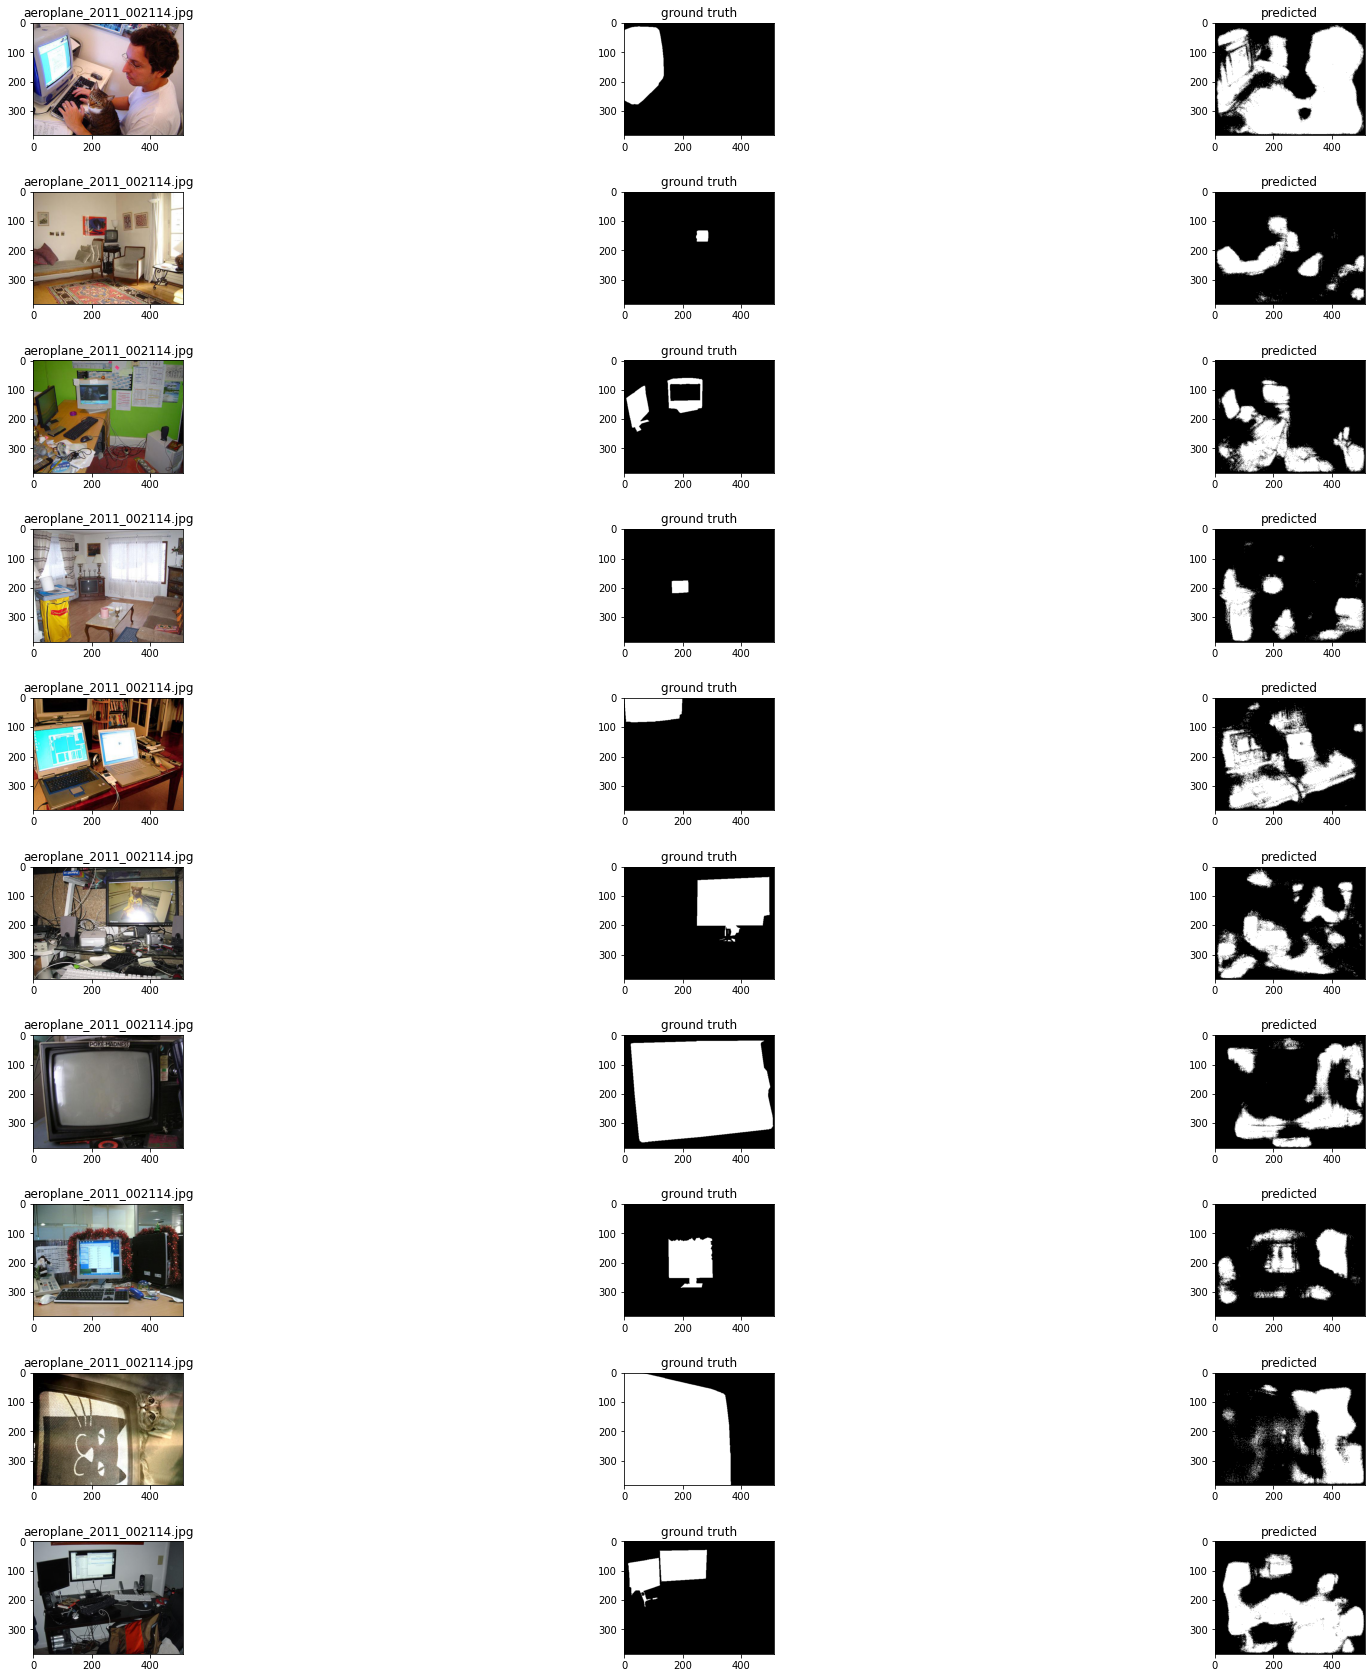

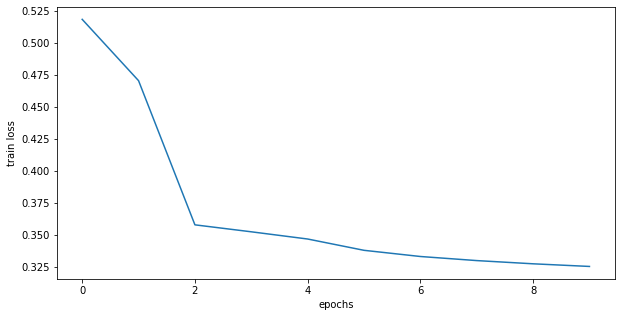

Epoch:11, Train loss:0.3236303925514221,Epoch Time:178.3138406276703
Epoch:12, Train loss:0.32206785678863525,Epoch Time:178.00333833694458
Epoch:13, Train loss:0.3204202353954315,Epoch Time:177.3284409046173


In [ ]:
tf.keras.backend.clear_session()
epochs = 30
freq = 5
bs = 32
num_batches = num_samples//bs
training_stats = []
iou_per_class_list = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    dataloader_img = iter(DataLoader(img_datasets, batch_size=bs,shuffle=False, num_workers=0))
    dataloader_mask = iter(DataLoader(mask_datasets, batch_size=bs,shuffle=False, num_workers=0))
    batch_losses = []
       
    for j in range(total_num_imgs//bs+1):
        batch_imgs = next(dataloader_img)[0].numpy()
        batch_masks = next(dataloader_mask)[0].numpy()
        batch_loss = train_step(model, batch_imgs, batch_masks, optimizer)
        batch_losses.append(batch_loss.numpy())
    end_time = time.time()
    train_loss = float(np.mean(batch_losses))
    #val_loss = compute_loss(model, input_data_val, input_mask_val)
    iou_per_class = calc_iou_per_class(model, epoch, freq)
    iou_per_class_list.append(iou_per_class)
    epoch_time = end_time - start_time

    training_stats.append({
      "epoch":epoch,
      "train loss":train_loss,
      "epoch time": epoch_time
    })
    print(f"Epoch:{epoch}, Train loss:{train_loss},Epoch Time:{epoch_time}")
    if epoch % freq == 0:
        plot_prediction(model, batch_imgs, batch_masks, img_filenames)
        plot_stats(pd.DataFrame(training_stats), "train loss")


In [ ]:
pd.DataFrame(iou_per_class_list)

,0
0,0.014466
1,0.041696
2,0.084534
3,0.092753
4,0.106763
5,0.119810
6,0.127632
7,0.127128
8,0.134696
9,0.131672


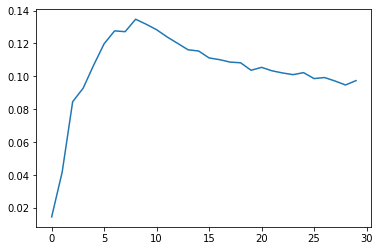

In [ ]:
plt.plot(iou_per_class_list)